In [28]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

From the [seq_network](./seq_network.ipynb) file, we described how a sequential network could be expressed as: $$f(x)=\xi_{i=1}^n R_i(A_ix+b_i)$$ where $\xi_{i=1}^nf_i(x)=f_n \circ f_{n-1}+\cdots \circ f_1(x)$, the $A_i$ are matrices and the $b_i$'s are the Bias Vectors. Typically the $R_i$ are the same for all layers (especially ReLU) except for the last one, where its the Identity Function.

# Training using Datasets:

We're gonna import the MNIST Dataset from TensorFlow:

In [51]:
x, y = torch.load('C://Users//DELL//Downloads//MNIST//MNIST//processed//training.pt')

x.shape, y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [52]:
y

tensor([5, 0, 4,  ..., 5, 6, 8])

As evident, the first image is the number 5, the second is the number 0, the third....

Plotting the number 4 (Second Index):

Text(0, 0.5, '$y$')

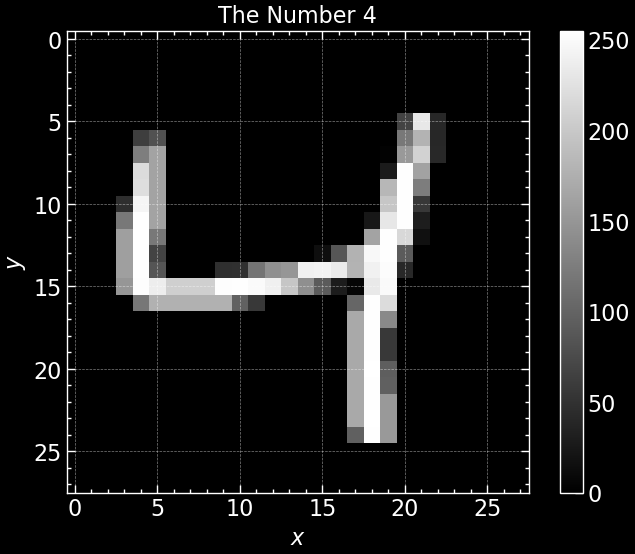

In [68]:
plt.imshow(x[2].numpy(), cmap = 'gray')
plt.colorbar()

plt.title(f'The Number {y[2].numpy()}')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# The One Hot Encoder:

Consider:

In [32]:
y_original = torch.tensor([2, 4, 3, 0, 1])
y_new = F.one_hot(y_original, num_classes = 6)

y_original, y_new

(tensor([2, 4, 3, 0, 1]),
 tensor([[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]]))

Each of the dataset elenments gets turned into a Unit Vector pointing in in the direction of the corresponding element, almost like a binary representation of the original dataset. Let's do this operation on our dataset:

In [33]:
y_new = F.one_hot(y, num_classes = 10)
y_new, y_new.shape

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0]]),
 torch.Size([60000, 10]))

This can also be thought as a collection of the known *Probabilities* that an image corresponds to a certain class.

The images are currently $28 \times 28$ matrices, but we wanna turn them into vectors of length $784$ using the property `.view()`:

In [34]:
x.view(-1, 784).shape

torch.Size([60000, 784])

# The PyTorch Dataset Object:

In [35]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes = 10).to(float)

    def __len__(self): 
        return self.x.shape[0]
    
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [36]:
train_DS = CTDataset('C://Users//DELL//Downloads//MNIST//MNIST//processed//training.pt')
test_DS = CTDataset('C://Users//DELL//Downloads//MNIST//MNIST//processed//test.pt')

len(train_DS)

60000

Slicing:

In [37]:
x_values, y_values = train_DS[0:4]
x_values.shape, y_values.shape

(torch.Size([4, 28, 28]), torch.Size([4, 10]))

# The PyTorch DataLoader Object:

We can then put the `Dataset` objects inside a `DataLoader` Class. This is useful because we could specify a `batch_size`. Each iteration through this class yields a tensor where the first dimension is equal to the `batch_size`. 

In [38]:
train_DL = DataLoader(train_DS, batch_size = 5)

for x, y in train_DL:
    print(x.shape); print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


Since `batch_size` is 5 here and there are 60000 images, the `DataLoader` object would have a length of 12000.

In [39]:
len(train_DL)

12000

# Cross-Entropy Loss:

Taken from [this](./seq_network.ipynb) file:

In [40]:
L = nn.CrossEntropyLoss()

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(784, 100, bias = True)
        self.Matrix2 = nn.Linear(100, 50, bias = True)
        self.Matrix3 = nn.Linear(50, 10, bias = True)
        
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)

        return x.squeeze()

In [41]:
f = MyNeuralNetwork()
f(x_values)

tensor([[ 0.0153, -0.0579,  0.0763,  0.0048,  0.1249, -0.0155,  0.0686,  0.1019,
         -0.1402,  0.0656],
        [-0.0340, -0.0648,  0.0650, -0.0394,  0.1112, -0.0023,  0.0630,  0.0533,
         -0.1605,  0.0805],
        [-0.1038, -0.0340,  0.0418, -0.0616,  0.1389, -0.0668,  0.0352,  0.0402,
         -0.1404,  0.0374],
        [-0.0679, -0.0542,  0.0556, -0.0414,  0.1283, -0.0451,  0.0504,  0.0623,
         -0.1099,  0.0436]], grad_fn=<SqueezeBackward0>)

This should eventually be equal to:

In [42]:
y_values

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

Loss Function between predictions:

In [43]:
L(f(x_values), y_values)

tensor(2.3023, dtype=torch.float64, grad_fn=<DivBackward1>)

We want such predictions `f(x_values)` to match the `y_values` values for all images. For this, the Loss Function `L(f(x_values, y_values))` should be minimized as much as possible. As such, we adjust the weights of `f` such that `L` becomes as small as possible.

# Training the Model

In [46]:
def train_model(DL, f, n_epochs = 20):
    opt = SGD(f.parameters(), lr = 0.01)
    L = nn.CrossEntropyLoss()

    losses = []
    epochs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(DL)
        
        for i, (x, y) in enumerate(DL):
            opt.zero_grad()
            
            loss_value = L(f(x), y)
            loss_value.backward()

            opt.step()

            epochs.append(epoch + i / N)
            losses.append(loss_value.item())

    return np.array(epochs), np.array(losses)

epoch_data, loss_data = train_model(train_DL, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Plotting the Loss Function:

Text(0, 0.5, '$L(f(x_values),y)$')

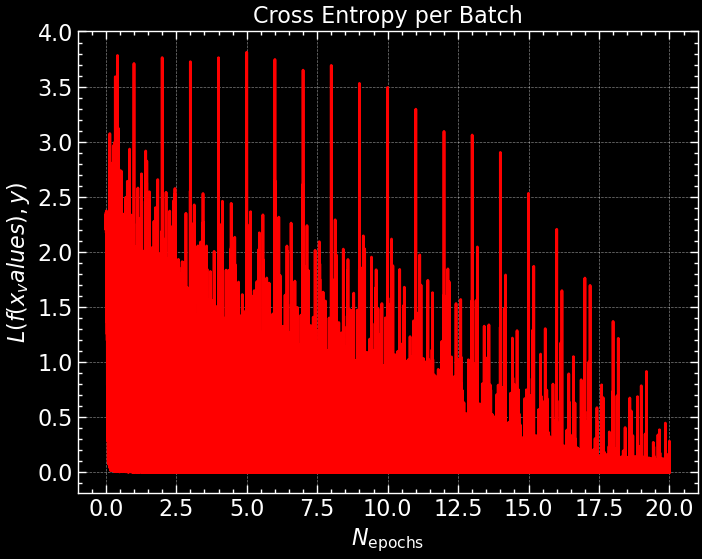

In [54]:
plt.plot(epoch_data, loss_data, color = 'red')

plt.title('Cross Entropy per Batch')
plt.xlabel(r'$N_{\mathrm{epochs}}$')
plt.ylabel(r'$L(f(x_values),y)$')

Each one of these datapoints corresponds to the Loss evaluated on a batch of 5 images. An entire epoch however, is 60000 images. We can average the Loss across all data per epoch to get it for all 60000 images. Since thereare 8 total epochs here, we'll split the array into 8 equal portions and take the mean of each:

Text(0, 0.5, 'Cross Entropy $L(f(x_{values}),y)$')

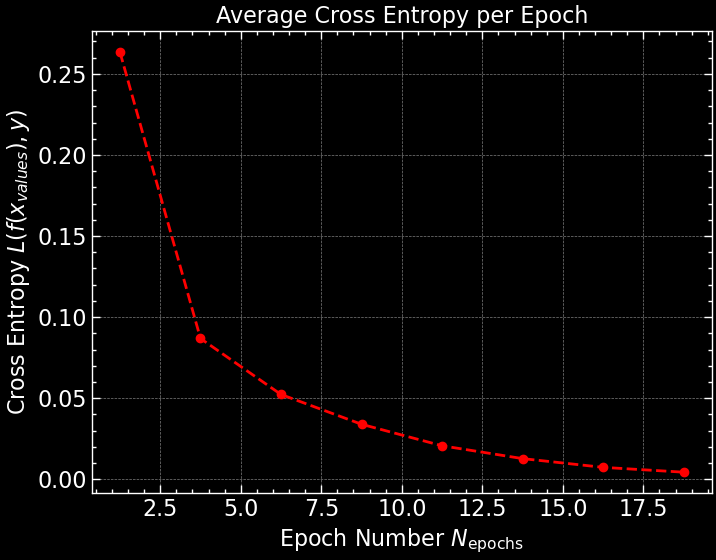

In [60]:
epoch_data_avg = epoch_data.reshape(8, -1).mean(axis = 1)
loss_data_avg = loss_data.reshape(8, -1).mean(axis = 1)

plt.plot(epoch_data_avg, loss_data_avg, 'o--', color = 'r')

plt.title('Average Cross Entropy per Epoch')
plt.xlabel(r'Epoch Number $N_{\mathrm{epochs}}$')
plt.ylabel(r'Cross Entropy $L(f(x_{values}),y)$')

Let's look at a sample image `y`:

In [58]:
y_sample = train_DS[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [59]:
x_sample = train_DS[0][0]

yhat_sample = f(x_sample)
yhat_sample 

tensor([ -9.1321,   0.0615,   0.9018,  28.4389, -23.2165,  32.6009, -11.7228,
         -3.6399,  -6.0989,   1.6909], grad_fn=<SqueezeBackward0>)

To understand this image, we should take the index of the maxima of $\hat y_{\mathrm{sample}}$:

In [61]:
torch.argmax(yhat_sample)

tensor(5)

Text(0, 0.5, '$y$')

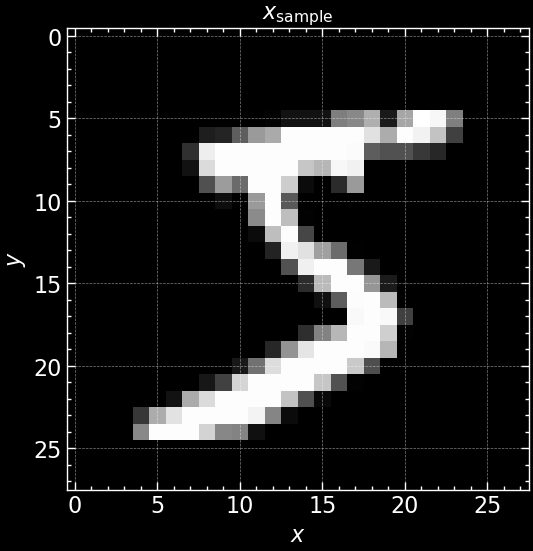

In [67]:
plt.imshow(x_sample, cmap = 'gray')

plt.title(r'$x_{\mathrm{sample}}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [70]:
x_values, y_values = train_DS[0:2000]
yhat_values = f(x_values).argmax(axis = 1)

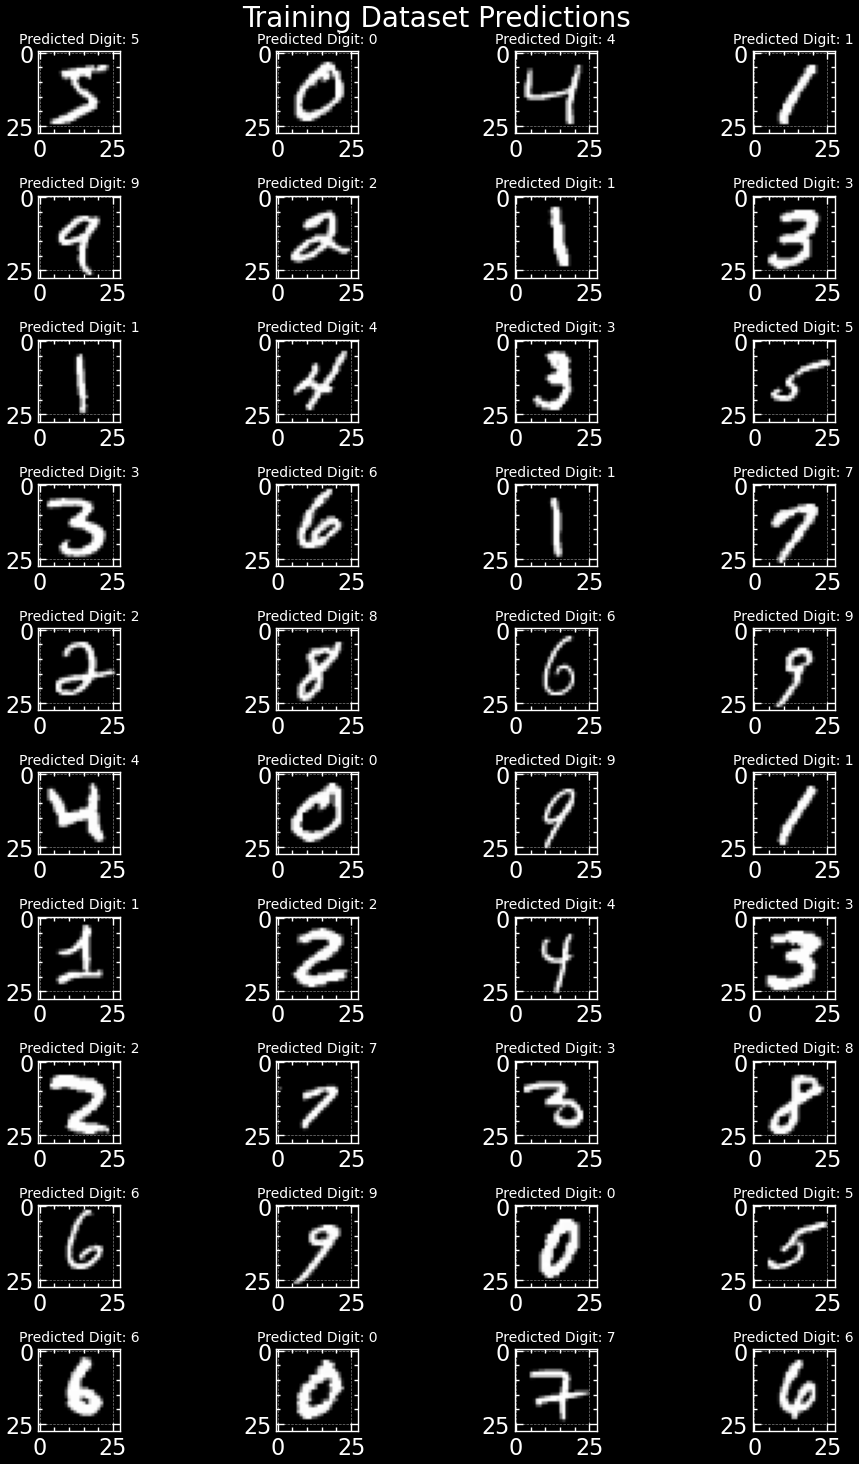

In [78]:
fig, ax = plt.subplots(10, 4, figsize = (10, 15))

for i in range(40):
    plt.subplot(10, 4, i + 1)
    plt.imshow(x_values[i], cmap = 'gray')

    plt.title(f'Predicted Digit: {yhat_values[i]}', size = 10)

fig.suptitle('Training Dataset Predictions', size = 20)
fig.tight_layout()

To test the generalizability of this model, we must evaluate its predictive power on the `test` dataset, which includes the images the model didn't see during training:

In [79]:
x_values, y_values = test_DS[:2000]
yhat_values = f(x_values).argmax(axis = 1)

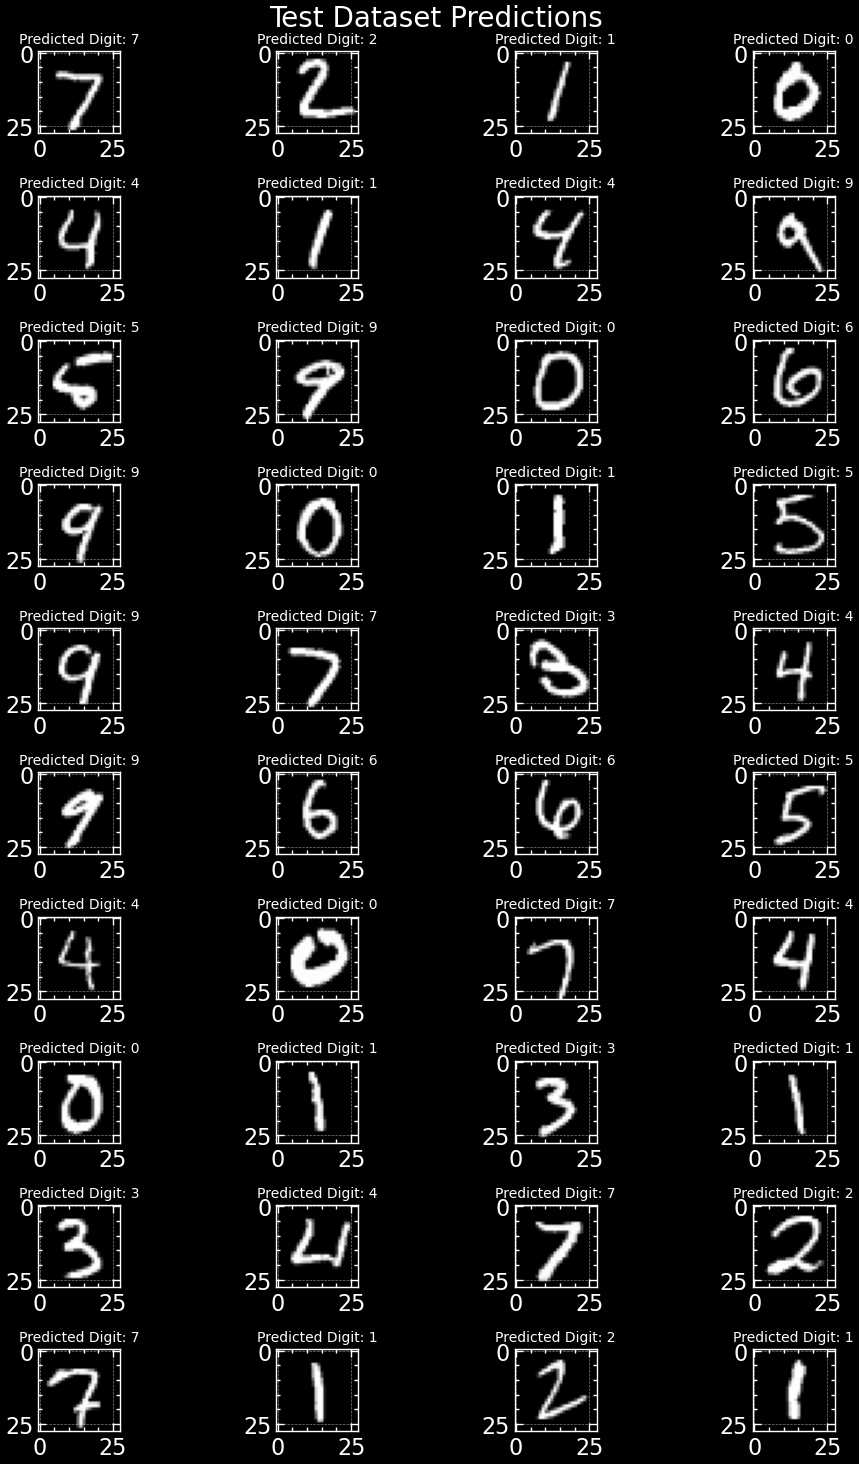

In [81]:
fig, ax = plt.subplots(10, 4, figsize = (10, 15))

for i in range(40):
    plt.subplot(10, 4, i + 1)
    plt.imshow(x_values[i], cmap = 'gray')

    plt.title(f'Predicted Digit: {yhat_values[i]}', size = 10)

fig.suptitle('Test Dataset Predictions', size = 20)
fig.tight_layout()